# DivNoising - Training
This notebook contains an example on how to train a DivNoising VAE.  This requires having a noise model (model of the imaging noise) which can be either measured from calibration data or estimated from raw noisy images themselves. If you haven't done so, please first run 'Convallaria-CreateNoiseModel.ipynb', which will download the data and create a noise model. 

In [1]:
# We import all our dependencies.
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset, DataLoader
from torch.nn import init
import os
import glob
from tifffile import imread
from matplotlib import pyplot as plt

import sys
sys.path.append('../../')
from divnoising import dataLoader
from divnoising import utils
from divnoising import training
from nets import model
from divnoising import histNoiseModel
from divnoising.gaussianMixtureNoiseModel import GaussianMixtureNoiseModel

import urllib
import os
import zipfile

from tqdm import tqdm

In [2]:
device = torch.device("cuda:0")

### Specify ```path``` to load data
Your data should be stored in the directory indicated by ```path```.

In [4]:
path="./data/Convallaria_diaphragm/"
observation= imread(path+'20190520_tl_25um_50msec_05pc_488_130EM_Conv.tif')

# Training Data Preparation

For training we need to follow some preprocessing steps first which will prepare the data for training purposes.

### Data preprocessing
We first divide the data into training and validation sets with 85% images allocated to training set  and rest to validation set. Then we augment the training data 8-fold by 90 degree rotations and flips.

In [5]:
train_images = observation[:int(0.85*observation.shape[0])]
val_images = observation[int(0.85*observation.shape[0]):]
print("Shape of training images:", train_images.shape, "Shape of validation images:", val_images.shape)
train_images = utils.augment_data(train_images)

Shape of training images: (85, 1024, 1024) Shape of validation images: (15, 1024, 1024)
Raw image size after augmentation (680, 1024, 1024)


We extract overlapping patches of size ```patch_size x patch_size``` from training and validation images. Specify the parameter ```patch_size```. The number of patches to be extracted is automatically determined depending on the size of images.

In [6]:
patch_size = 128
img_width = observation.shape[2]
img_height = observation.shape[1]
num_patches = int(float(img_width*img_height)/float(patch_size**2)*2)

x_train_crops = utils.extract_patches(train_images, patch_size, num_patches)
x_val_crops = utils.extract_patches(val_images, patch_size, num_patches)

100%|██████████| 15/15 [00:00<00:00, 157.53it/s]


Finally, we compute the mean and standard deviation of our combined train and validation sets and do some additional preprocessing.

In [7]:
data_mean, data_std = utils.getMeanStdData(train_images, val_images)

x_train, x_val = utils.convertToFloat32(x_train_crops, x_val_crops)
x_train_extra_axis = x_train[:,np.newaxis]
x_val_extra_axis = x_val[:,np.newaxis]

x_train_tensor = utils.convertNumpyToTensor(x_train_extra_axis)
x_val_tensor = utils.convertNumpyToTensor(x_val_extra_axis)

In [8]:
print("Shape of training tensor:", x_train_tensor.shape)

Shape of training tensor: torch.Size([87040, 1, 128, 128])


# Configure DivNoising model

Here we specify some parameters of our DivNoising network needed for training. <br> 
The parameter <code>z_dim</code> specifies the size of the bottleneck dimension corresponding to each pixel. <br> 
The parameter <code>in_channels</code> specifies the number of input channels which for this dataset is 1.<br> 
We currently have support for only 1 channel input but it may be extended to arbitrary number of channels in the future. <br>
The parameter <code>init_filters</code> specifies the number of filters in the first layer of the network. <br>
The parameter <code>n_depth</code> specifies the depth of the network. 
The parameter <code>batch_size</code> specifies the batch size used for training. <br>
The parameter <code>n_filters_per_depth</code> specifies the number of convolutions per depth. <br>
The parameter <code>directory_path</code> specifies the directory where the model will be saved. <br>
The parameter <code>n_epochs</code> specifies the number of training epochs. <br>
The parameter <code>lr</code> specifies the learning rate. <br>
The parameter <code>val_loss_patience</code> specifies the number of epochs after which training will be terminated if the validation loss does not decrease by a factor of 1e-6. <br>
The parameter <code>noiseModel</code> is the noise model you want to use. Run the notebook  ```Convallaria-CreateNoiseModel.ipynb```, if you have not yet generated the noise model for this dataset yet. If set to None a Gaussian noise model is used.<br>
The parameter <code>gaussian_noise_std</code> is the standard deviation of the Gaussian noise model. This should only be set if 'noiseModel' is None. Otherwise, if you have created a noise model already, set it to ```None```. <br>
The parameter <code>model_name</code> specifies the name of the model with which the weights will be saved for prediction later.

__Note:__ We observed good performance of the DivNosing network for most datasets with the default settings in the next cell. However, we also observed that playing with the paramaters sensibly can also improve performance.

In [9]:
z_dim=64
in_channels = 1
init_filters = 32
n_filters_per_depth=2
n_depth=2
batch_size=32
directory_path = "./"
n_epochs = int(22000000/(x_train_tensor.shape[0])) # A heurisitc to set the number of epochs
lr=0.001
val_loss_patience = 100
gaussian_noise_std = None
#noise_model_params= np.load("/home/krull/fileserver/experiments/ReDo/convallaria/GMMNoiseModel_convallaria_3_2_calibration.npz")
noise_model_params= np.load("data/Convallaria_diaphragm/GMMNoiseModel_convallaria_3_2_calibration.npz")
noiseModel = GaussianMixtureNoiseModel(params = noise_model_params, device = device)
model_name = "convallaria-"

# Train network

__Note:__ We observed that for certain datasets, the KL loss goes towards 0. This phenomenon is called ```posterior collapse``` and is undesirable.
We prevent it by aborting and restarting the training once the KL dropy below a threshold (```kl_min```).
An alternative approach is a technique called *KL Annealing* where we increase the weight on KL divergence loss term from 0 to 1 gradually in a numer of steps.
This cann be activated by setting the parameter ```kl_annealing``` to ```True```. <br>
The parameter ```kl_start``` specifies the epoch when KL annelaing will start. <br>
The parameter ```kl_annealtime``` specifies until which epoch KL annealing will be operational. <br>
If the parameter ```kl_annealing``` is set to ```False```, the values of ```kl_start``` and  ```kl_annealtime``` are ignored.

In [ ]:
train_dataset = dataLoader.MyDataset(x_train_tensor,x_train_tensor)
val_dataset = dataLoader.MyDataset(x_val_tensor,x_val_tensor)

trainHist, reconHist, klHist, valHist = None, None, None, None
attempts=0
while trainHist is None:
    attempts+=1
    print('start training: attempt '+ str(attempts))
    vae = model.VAE(z_dim=z_dim, 
                    in_channels=in_channels,
                    init_filters = init_filters, 
                    n_filters_per_depth=n_filters_per_depth,
                    n_depth=n_depth)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    trainHist, reconHist, klHist, valHist = training.trainNetwork(net=vae, train_loader=train_loader, 
                                                                     val_loader=val_loader,
                                                                     device=device,directory_path=directory_path,
                                                                     model_name=model_name,
                                                                     n_epochs=n_epochs, batch_size=batch_size,lr=lr,
                                                                     val_loss_patience = val_loss_patience,
                                                                     kl_annealing = False,
                                                                     kl_start = 0, 
                                                                     kl_annealtime = 3,
                                                                     kl_min=1e-5,
                                                                     data_mean =data_mean,data_std=data_std, 
                                                                     noiseModel = noiseModel,
                                                                     gaussian_noise_std = gaussian_noise_std)
    

start training: attempt 1
postersior collapse: aborting
start training: attempt 2
postersior collapse: aborting
start training: attempt 3
Epoch[1/252] Training Loss: 6.474 Reconstruction Loss: 6.306 KL Loss: 0.167
kl_weight: 1.0
saving ./convallaria-last_vae.net
saving ./convallaria-best_vae.net
Patience: 0 Validation Loss: 6.30342960357666 Min validation loss: 6.30342960357666
Time for epoch: 151seconds
Est remaining time: 10:31:41 or 37901 seconds
----------------------------------------


# Plotting losses

In [11]:
trainHist=np.load(directory_path+"/train_loss.npy")
reconHist=np.load(directory_path+"/train_reco_loss.npy")
klHist=np.load(directory_path+"/train_kl_loss.npy")
valHist=np.load(directory_path+"/val_loss.npy")

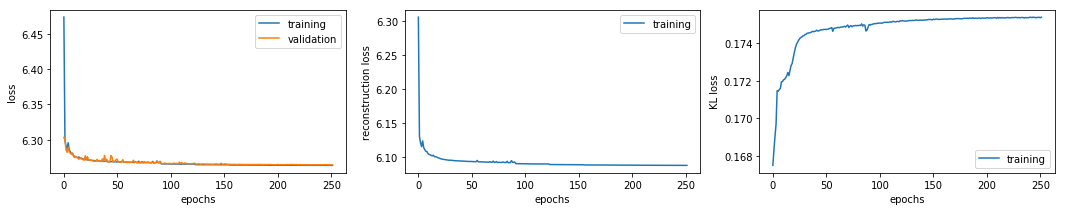

In [14]:
plt.figure(figsize=(18, 3))
plt.subplot(1,3,1)
plt.plot(trainHist,label='training')
plt.plot(valHist,label='validation')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

plt.subplot(1,3,2)
plt.plot(reconHist,label='training')
plt.xlabel("epochs")
plt.ylabel("reconstruction loss")
plt.legend()

plt.subplot(1,3,3)
plt.plot(klHist,label='training')
plt.xlabel("epochs")
plt.ylabel("KL loss")
plt.legend()
plt.show()